# CS 7641 Homework 1 - Fall 2020



In [82]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, svm, datasets
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from visualization import plot_2d_data, plot_2d_classifier
import os

from visualization import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

## Loading Datasets

In [83]:
heart_data = pd.read_csv("./data/heart.csv")
heart_data_X = heart_data.drop("target", axis=1)/256
heart_data_y = heart_data.target

heart_train_X, heart_test_X, heart_train_y, heart_test_y = train_test_split(heart_data_X, heart_data_y, test_size=0.2, random_state=100)

## Decision Tree

In [84]:
# https://scikit-learn.org/stable/modules/tree.html
# https://deepstat.tistory.com/44
# https://jcabelloc.github.io/machine%20learning/2019/02/27/classification-task.html

dtc_heart = tree.DecisionTreeClassifier(random_state=100)
dtc_heart.fit(heart_train_X, heart_train_y)
heart_predict_y = dtc_heart.predict(heart_test_X)
print(f"Accuracy Score: {100* accuracy_score(heart_test_y, heart_predict_y)}%")


Accuracy Score: 73.77049180327869%


## Neural Network

## Boosting

In [109]:
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))
stump = DecisionTreeClassifier(max_depth=1, random_state = 100)
 
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(heart_train_X, heart_train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, 
                                   n_estimators=10, learning_rate=rate)
        model.fit(heart_train_X.values[trn, :], heart_train_y.values[trn])
        trn_err[i, j] = 1 - accuracy_score(heart_train_y.values[trn], model.predict(heart_train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(heart_train_y.values[val], model.predict(heart_train_X.values[val, :]))
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)
print(f'Training Error {trn_err}, Value Error {val_err}')

Training Error [0.16849871 0.16345707 0.15106329 0.13222213 0.12349385 0.12121295
 0.11800406 0.12626094 0.12534774 0.14507039], Value Error [0.17683333 0.18616667 0.17416667 0.1775     0.15666667 0.16933333
 0.1485     0.15733333 0.1775     0.18583333]


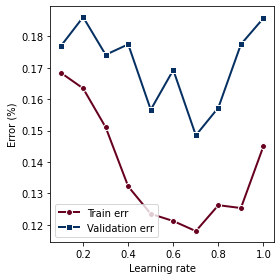

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [112]:
n_estimator_steps, n_folds = 2, 10
number_of_stumps = np.arange(2, 40, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(heart_train_X, heart_train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(heart_train_X.values[trn, :], heart_train_y.values[trn])

        trn_err[i, j] = 1 - accuracy_score(heart_train_y.values[trn], 
                                           model.predict(heart_train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(heart_train_y.values[val], 
                                           model.predict(heart_train_X.values[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

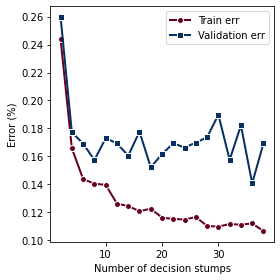

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [124]:
shallow_tree = DecisionTreeClassifier(max_depth=1)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                                  n_estimators=16, learning_rate=0.75)
ensemble.fit(heart_train_X, heart_train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.75, n_estimators=16)

In [125]:
ypred = ensemble.predict(heart_test_X)
acc = accuracy_score(heart_test_y, ypred)
acc

0.8524590163934426

## SVM

In [91]:
model = svm.SVC(kernel='rbf', C=30, gamma='auto')
model.fit(heart_train_X, heart_train_y)
model.score(heart_test_X, heart_test_y)

0.7868852459016393

In [92]:
from sklearn.model_selection import cross_val_score

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report

# https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

# model_OVRC = OneVsRestClassifier(svm.LinearSVC(class_weight='balanced', max_iter=10000))
# svm_model = svm.LinearSVC(class_weight='balanced', max_iter=100000)
svm_model = svm.SVC()

parameters = {'C':(0.1, 0.5, 1, 2, 5, 10, 20, 40, 100), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')
         }

model = GridSearchCV(svm_model, parameters, cv=5)

model.fit(heart_train_X, heart_train_y)
model_predict = model.predict(heart_test_X)

print(classification_report(heart_test_y, model_predict))


              precision    recall  f1-score   support

           0       0.96      0.70      0.81        33
           1       0.73      0.96      0.83        28

    accuracy                           0.82        61
   macro avg       0.84      0.83      0.82        61
weighted avg       0.85      0.82      0.82        61



## KNN

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [95]:
KNN_Model = KNeighborsClassifier(n_neighbors=30).fit(heart_train_X, heart_train_y)

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

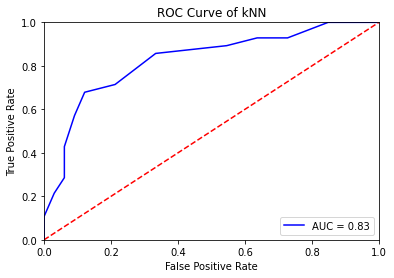

In [96]:
heart_y_scores = KNN_Model.predict_proba(heart_test_X)
fpr, tpr, threshold = roc_curve(heart_test_y, heart_y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()